# Introduction

For this demonstration we will use the data from the ALMA First Look at Imaging CASAguide (https://casaguides.nrao.edu/index.php/First_Look_at_Imaging).


# Installation

- S3Fs is a pythonic file interface to AWS S3 cloud storage (all the needed data is stored here).
- ngcasa is the prototype for the next generation of CASA software.
- graphviz is required for visualizing the task graph.



In [9]:
import os
os.system("pip install s3fs")
os.system("pip install ngcasa==0.0.5")
os.system("pip install graphviz")
print("complete")

complete


# Load Data from AWS S3 Cloud


In [ ]:
import s3fs
import xarray as xr

# Initialize the S3 "file system"
s3 = s3fs.S3FileSystem(anon=True, requester_pays=False)

# Specify AWS S3 paths
bucket = "cngi-prototype-test-data/"
s3_path = bucket+"test_data/"

if s3.isdir(s3_path): # it's working
    print("Files available for access:")
    print(s3.listdir(s3_path))

ddi = "0"
s3_vis = s3_path+"sis14_twhya_field_5_lsrk_pol_xx.vis.zarr/"+ddi
s3_metadata = s3_path+"sis14_twhya_field_5_lsrk_pol_xx.vis.zarr/global"

# Convert object stores to our desired MutableMapping interface
store_vis = s3fs.S3Map(root=s3_vis, s3=s3, check=False)
store_global = s3fs.S3Map(root=s3_metadata, s3=s3, check=False)

# Read zarr files
vis_dataset = xr.open_zarr(store=store_vis, consolidated=True)
#vis_dataset = xr.open_zarr(store=store_vis, consolidated=False)

#Saving a local copy of the dataset
local_store_file = "sis14_twhya_field_5_lsrk_pol_xx.vis.zarr"
xr.Dataset.to_zarr(vis_dataset,store=local_store_file, mode='w',consolidated=True)
vis_dataset = xr.open_zarr(store=local_store_file, consolidated=True,chunks={'chan':192})

print('##############################################')
print(vis_dataset)
print('##############################################')
print('complete')

Files available for access:
[{'Key': 'cngi-prototype-test-data/test_data/', 'LastModified': datetime.datetime(2020, 3, 4, 16, 38, 17, tzinfo=tzutc()), 'ETag': '"d41d8cd98f00b204e9800998ecf8427e"', 'Size': 0, 'StorageClass': 'STANDARD', 'type': 'file', 'size': 0, 'name': 'cngi-prototype-test-data/test_data/'}, {'Key': 'cngi-prototype-test-data/test_data/continuum_twhya_standard_gridder.img.zarr', 'Size': 0, 'StorageClass': 'DIRECTORY', 'type': 'directory', 'size': 0, 'name': 'cngi-prototype-test-data/test_data/continuum_twhya_standard_gridder.img.zarr'}, {'Key': 'cngi-prototype-test-data/test_data/cube_twhya_standard_gridder.img.zarr', 'Size': 0, 'StorageClass': 'DIRECTORY', 'type': 'directory', 'size': 0, 'name': 'cngi-prototype-test-data/test_data/cube_twhya_standard_gridder.img.zarr'}, {'Key': 'cngi-prototype-test-data/test_data/sis14_twhya_chan_avg_field_5_lsrk_pol_xx.vis.zarr', 'Size': 0, 'StorageClass': 'DIRECTORY', 'type': 'directory', 'size': 0, 'name': 'cngi-prototype-test-data

# Initialize the Processing Environment
InitializeFramework instantiates a client object (does not need to be returned and saved by caller). Once this object exists, all Dask objects automatically know to use it for parallel execution.  

Omitting this step will cause the subsequent Dask dataframe operations to use the default built-in scheduler for parallel execution (which can actually be faster on local machines anyway)

Google Colab doesn't really support the dask.distributed environment particularly well.  The code is shown here commented out for reference only.

In [ ]:
# normally you would want to run something like this on a local machine
#from cngi.direct import InitializeFramework
#client = InitializeFramework(workers=2, memory='6GB')
#print(client)

# Storage Parameters
All of the ngcasa.synthesis.imaging functions require a dict called storage_parms. This dict tells tha function to do one of the following:
- Generates Dask graph with no execution (the graph is part of the returened xarray dataset).
    - storage_parms['to_disk'] = False
- Generates dask graph, execute and save dataset to disk in zarr format.
    - storage_parms['to_disk'] = True, storage_parms['append'] = False
- Generates dask graph, execute and append data variables to existing zarr dataset on disk. \
    - storage_parms['to_disk'] = True, storage_parms['append'] = True

In [5]:
storage_parms = {}
storage_parms['to_disk'] = True  #bool, default: False
storage_parms['append'] = True   #bool, default: False
storage_parms['outfile'] = local_store_file #str, No default, #storage_parms['outfile'] is same as openfile since data variables will be appended to dataset.
#storage_parms['compressor'], #Blosc, Default: Blosc(cname='zstd', clevel=2, shuffle=0)

# Make Imaging Weights

In [6]:
from ngcasa.synthesis.imaging import make_imaging_weights

imaging_weights_parms = {}
#imaging_weights_parms['weighting'] #str, default:'natural', acceptable values 'natural','uniform','briggs','briggs_abs'
imaging_weights_parms['robust'] = 0.6 #number, default:0.5, acceptable values [-2,2]
imaging_weights_parms['imsize'] = [200,200]   #list 2 int, no default
imaging_weights_parms['cell']  = [0.04,0.04]  #list 2 number, no default, #units of arcseconds
#imaging_weights_parms['uvw_name']  #str, default:'UVW'
#imaging_weights_parms['data_name'] #str, default:'data_name'
#imaging_weights_parms['imaging_weight_name'] #str, default:'IMAGING_WEIGHT'
imaging_weights_parms['chan_mode'] = 'continuum' #str, default:'continuum', acceptable values 'continuum','cube' #Setting to 'cube' follows the same approach as perchanweightdensity in casa tclean

imaging_weights_parms['weighting'] = 'natural'
imaging_weights_parms['imaging_weight_name'] = 'IMAGING_WEIGHT_NAT'
make_imaging_weights(vis_dataset, imaging_weights_parms, storage_parms)

imaging_weights_parms['weighting'] = 'uniform'
imaging_weights_parms['imaging_weight_name'] = 'IMAGING_WEIGHT_UNI'
make_imaging_weights(vis_dataset, imaging_weights_parms, storage_parms)

imaging_weights_parms['weighting'] = 'briggs'
imaging_weights_parms['imaging_weight_name'] = 'IMAGING_WEIGHT_BRG'
vis_dataset=make_imaging_weights(vis_dataset, imaging_weights_parms, storage_parms)

######################### Start make_imaging_weights #########################
Setting default data_name  to  DATA
Setting default uvw_name  to  UVW
Setting default compressor  to  Blosc(cname='zstd', clevel=2, shuffle=NOSHUFFLE, blocksize=0)
WEIGHT data variable found, will use WEIGHT to calculate  IMAGING_WEIGHT_NAT
Atempting to add  IMAGING_WEIGHT_NAT  to  sis14_twhya_field_5_lsrk_pol_xx.vis.zarr
time_to_calc_and_store  0.44292402267456055
##################### Finished appending imaging_weights #####################
######################### Start make_imaging_weights #########################
Setting default data_name  to  DATA
Setting default uvw_name  to  UVW
Setting default compressor  to  Blosc(cname='zstd', clevel=2, shuffle=NOSHUFFLE, blocksize=0)
WEIGHT data variable found, will use WEIGHT to calculate  IMAGING_WEIGHT_UNI
Atempting to add  IMAGING_WEIGHT_UNI  to  sis14_twhya_field_5_lsrk_pol_xx.vis.zarr
time_to_calc_and_store  1.028681993484497
##################### Finishe

# Make PSF

######################### Start make_psf #########################
Setting default data_name  to  DATA
Setting default uvw_name  to  UVW
Setting default sum_weight_name  to  PSF_SUM_WEIGHT
Setting default compressor  to  Blosc(cname='zstd', clevel=2, shuffle=NOSHUFFLE, blocksize=0)
Saving dataset to  twhya_standard_gridder_lsrk_mfs.img.zarr
************************
self.sources [dask.array<correct_image, shape=(200, 200, 1, 1), dtype=float64, chunksize=(200, 200, 1, 1), chunktype=numpy.ndarray>, dask.array<transpose, shape=(1, 1), dtype=float64, chunksize=(1, 1), chunktype=numpy.ndarray>]
self.targets [<zarr.core.Array '/PSF_NAT' (200, 200, 1, 1) float64>, <zarr.core.Array '/PSF_SUM_WEIGHT' (1, 1) float64>]
self.regions [None, None]
compute True
lock None
regions [None, None]
************************
1.506964921951294
time_to_calc_and_store  1.5233409404754639
##################### Created new dataset with make_psf #####################
######################### Start make_psf ########

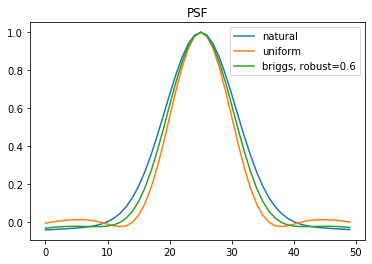

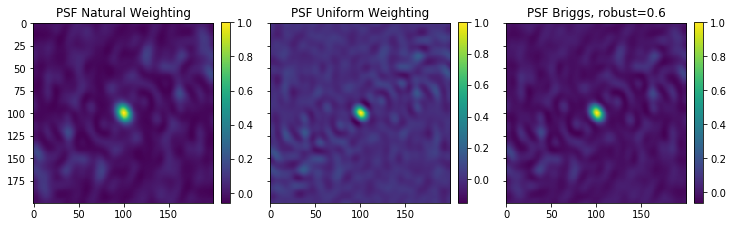

In [7]:
from ngcasa.synthesis.imaging import make_psf
import matplotlib.pylab as plt

grid_parms = {}
grid_parms['chan_mode'] = 'continuum'#'continuum'#cube or continuum
grid_parms['imsize'] =  [200,200]
grid_parms['cell'] = [0.04, 0.04]
grid_parms['oversampling'] = 100
grid_parms['support'] = 7
grid_parms['fft_padding'] =  1.2


storage_parms['append'] = False #'append' needs to be changed to false since a img.zarr file does not exist yet.
storage_parms['outfile'] = 'twhya_standard_gridder_lsrk_mfs.img.zarr' #Change outfile name to image file.

grid_parms['imaging_weight_name'] = 'IMAGING_WEIGHT_NAT'
grid_parms['image_name'] = 'PSF_NAT'
img_dataset = make_psf(vis_dataset,grid_parms,storage_parms)

storage_parms['append'] = True #Since storage_parms['outfile'] has been created we can now append the other psf files
grid_parms['imaging_weight_name'] = 'IMAGING_WEIGHT_UNI'
grid_parms['image_name'] = 'PSF_UNI'
img_dataset = make_psf(vis_dataset,grid_parms,storage_parms)

grid_parms['imaging_weight_name'] = 'IMAGING_WEIGHT_BRG'
grid_parms['image_name'] = 'PSF_BRG'
img_dataset = make_psf(vis_dataset,grid_parms,storage_parms)

print(img_dataset)

## Plot PSF files

plt.figure()
plt.plot(img_dataset.PSF_NAT[100,75:125,0,0],label='natural')
plt.plot(img_dataset.PSF_UNI[100,75:125,0,0],label='uniform')
plt.plot(img_dataset.PSF_BRG[100,75:125,0,0],label='briggs, robust='+str(imaging_weights_parms['robust']))
plt.legend()
plt.title('PSF')
plt.show()


fig0, ax0 = plt.subplots(1, 3, sharey=True,figsize=(12, 5))
im0 = ax0[0].imshow(img_dataset.PSF_NAT[:,:,0,0])
im1 = ax0[1].imshow(img_dataset.PSF_UNI[:,:,0,0])
im2 = ax0[2].imshow(img_dataset.PSF_BRG[:,:,0,0])
ax0[0].title.set_text('PSF Natural Weighting')
ax0[1].title.set_text('PSF Uniform Weighting')
ax0[2].title.set_text('PSF Briggs, robust='+str(imaging_weights_parms['robust']))
fig0.colorbar(im0, ax=ax0[0], fraction=0.046, pad=0.04)
fig0.colorbar(im1, ax=ax0[1], fraction=0.046, pad=0.04)
fig0.colorbar(im2, ax=ax0[2], fraction=0.046, pad=0.04)
plt.show()

# Make Dirty Images

######################### Start make_dirty_image #########################
Setting default data_name  to  DATA
Setting default uvw_name  to  UVW
Setting default sum_weight_name  to  SUM_WEIGHT
Setting default compressor  to  Blosc(cname='zstd', clevel=2, shuffle=NOSHUFFLE, blocksize=0)
Atempting to add  ['DIRTY_IMAGE_NAT', 'SUM_WEIGHT']  to  twhya_standard_gridder_lsrk_mfs.img.zarr
time_to_calc_and_store  2.3019230365753174
##################### Finished appending psf #####################
######################### Start make_dirty_image #########################
Setting default data_name  to  DATA
Setting default uvw_name  to  UVW
Setting default sum_weight_name  to  SUM_WEIGHT
Setting default compressor  to  Blosc(cname='zstd', clevel=2, shuffle=NOSHUFFLE, blocksize=0)
Atempting to add  ['DIRTY_IMAGE_UNI', 'SUM_WEIGHT']  to  twhya_standard_gridder_lsrk_mfs.img.zarr
time_to_calc_and_store  2.220729112625122
##################### Finished appending psf #####################
###########

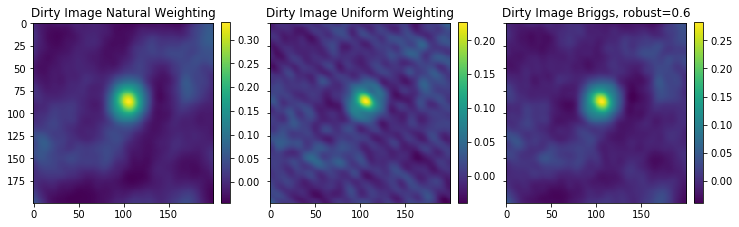

In [8]:
from ngcasa.synthesis.imaging import make_dirty_image

grid_parms['imaging_weight_name'] = 'IMAGING_WEIGHT_NAT'
grid_parms['image_name'] = 'DIRTY_IMAGE_NAT'
img_dataset = make_dirty_image(vis_dataset,grid_parms,storage_parms)

storage_parms['append'] = True #Since storage_parms['outfile'] has been created we can now append the other psf files
grid_parms['imaging_weight_name'] = 'IMAGING_WEIGHT_UNI'
grid_parms['image_name'] = 'DIRTY_IMAGE_UNI'
img_dataset = make_dirty_image(vis_dataset,grid_parms,storage_parms)

grid_parms['imaging_weight_name'] = 'IMAGING_WEIGHT_BRG'
grid_parms['image_name'] = 'DIRTY_IMAGE_BRG'
img_dataset = make_dirty_image(vis_dataset,grid_parms,storage_parms)


fig0, ax0 = plt.subplots(1, 3, sharey=True,figsize=(12, 5))
im0 = ax0[0].imshow(img_dataset.DIRTY_IMAGE_NAT[:,:,0,0])
im1 = ax0[1].imshow(img_dataset.DIRTY_IMAGE_UNI[:,:,0,0])
im2 = ax0[2].imshow(img_dataset.DIRTY_IMAGE_BRG[:,:,0,0])
ax0[0].title.set_text('Dirty Image Natural Weighting')
ax0[1].title.set_text('Dirty Image Uniform Weighting')
ax0[2].title.set_text('Dirty Image Briggs, robust='+str(imaging_weights_parms['robust']))
fig0.colorbar(im0, ax=ax0[0], fraction=0.046, pad=0.04)
fig0.colorbar(im1, ax=ax0[1], fraction=0.046, pad=0.04)
fig0.colorbar(im2, ax=ax0[2], fraction=0.046, pad=0.04)
plt.show()